In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

## Steps:

1) open sound file

2) fft

3) identify top peaks (all peaks above threshold)

TODO:

4) convert peaks to notes NOTE: guitar must be tuned

5) put notes in a set (no repeats)

6) send set of notes to website for identification

## Ideas:

- can the sound be read straight into an array rather than saving as wav and then reading it?
- trim silence from audio file (only start reording once the volume is above threshold (this is website side, not in this code)
- trim frequency spectrum to within range of guitar frequencies (does this improve speed? The frequencies outside this range are probably not going to have high enough amplitudes to matter anyways))

# parameters:
- threshold for a frequency to count as a "main frequency", currently set to max_amplitude/5

In [38]:
def freqToNote(freq):
    '''
    TODO: need a table of note frequencies. Limit to range of frequencies? Pick closest frequency in table
    '''
    pass

def getSignal(fileName):
    '''
    Read the given .wav file and return the signal
    '''
    # Read the .wav file to get the sampling rate and the data contained in the file
    sampFreq, sound = wavfile.read(fileName)

    #    sound.dtype = 'int16'means that the sound pressure values are mapped to integer values that can range from -2^15 to (2^15)-1. The samples are taken 44100 times per second.
    
    #    We can convert our sound (numpy) array to floating point values ranging from -1 to 1 as follows:
    sound = sound / 2.0**15 


    # Duration of the chord/sound (in seconds):
    duration = sound.shape[0] / sampFreq


    # To get the proper time on the x-axis we have to generate a numpy array using sampFreq:
    time = np.arange(sound.shape[0]) / sound.shape[0] * duration

    # select a single channel:
    signal = sound[:,0] 
    
    plt.plot(time, signal)
    plt.xlabel("Time(s)")
    plt.ylabel("Amplitude")
    plt.title("Signal")
    plt.show()
    
    return signal, sampFreq
    


In [47]:
def Identify(fileName):
    '''
    Identifies the chord in the file with name fileName using Fourier analysis.
    
    Returns the chord (list of the notes in the major triad), the root note, and the duration the chord 
    plays for (ie. length of the wav file) in seconds
    '''
    
    signal, sampFreq = getSignal(fileName)

    # Find the amplitude of each frequency using fast fourier transform
    fft_spectrum = np.fft.rfft(signal)
    amp = np.abs(fft_spectrum)
    freq = np.fft.rfftfreq(signal.size, d=1./sampFreq)
    
    # Plot the frequencies    
    f1 = plt.figure()
    plt.plot(freq[:3500], amp[:3500])
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.title("Frequency spectrum")


   
    threshold = np.max(amp)/5    
    
    # amplitudes that are above the threshold
    main_amp = np.where(amp>threshold, amp, 0)  # similar to amp, but amplitudes of all frequencies that are below the threshold are set to zero
    
    # Plot the frequencies    
    f1 = plt.figure()
    plt.plot(freq[:3500], main_amp[:3500])
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.title("Main frequencies in spectrum")
    
    return
    
    fund = []
    
    # Finding the three fundamental frequencies
    for i in range(3):
        # Getting the next fundamental frequency
        max_index = np.argmax(amp)
        fund_freq = freq[max_index]
        
        #sometimes the highest amplitude didn't correspond to the fundamental frequency, so we have to 
        # make sure that fund_freq is really the fundamental frequency,, and if not, get the true fundamental frequency
        fund_freq = checkFundamental(freq, amp, fund_freq, main_amp)
        


        # remove overtones of the fundamental frequency (so that the remaining frequency with the highest amplitude is the
        #                                                      fundamental frequency of the next note in the chord)        
        amp = removeOvertones(freq, amp, fund_freq)
        
        fund.append(fund_freq)
    
    # get names of notes from fundamental frequencies
    notes = freqToNote(fund)
    
    # identify the chord and the root node
    root = identify_root(notes)
    chord = major_chord(root)
    
    # now that the chord is known, display the plot along with the chord name
    plt.title(root + " Major Chord")
    plt.show()
    

    
    return chord,root, duration


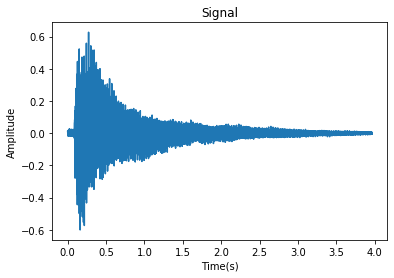

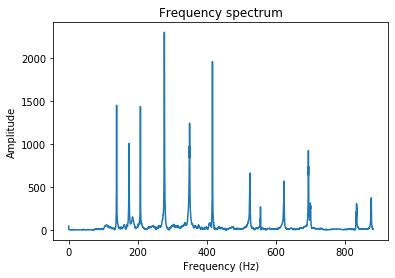

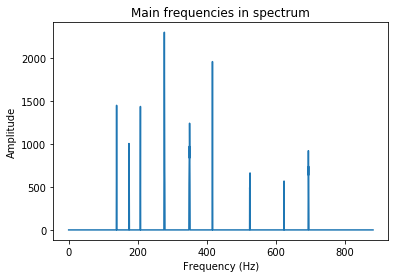

In [48]:
Identify('C#.wav')

In [97]:
# read, rewrite, and save table of not frequencies
import pandas as pd

data = np.genfromtxt('note_frequency_table.csv', delimiter=',', encoding="utf-8-sig", dtype=None, invalid_raise = False, comments=None)



# create pandas dataframe
data = pd.DataFrame(data[1:, :], columns=data[0])
data

,Note Name,Frequency (Hz)
0,C,16.351
1,C#,17.324
2,D,18.354
3,D# / Eb,19.445
4,E,20.601
...,...,...
115,G,12543.856
116,G# / Ab,13289.752
117,A,14080
118,A# / Bb,14917.24
